In [ ]:
!pip install torch transformers matplotlib

In [3]:
import pandas as pd
import time
import torch
from torch import nn
from collections import defaultdict
from matplotlib import pyplot as plt

from transformers import BertTokenizer

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# First download the dataset from https://www.kaggle.com/datasets/asaniczka/product-titles-text-classification
TITLES_TO_CATEGORIES_CSV = './titles_to_categories.csv'

In [5]:
df = pd.read_csv(TITLES_TO_CATEGORIES_CSV)

In [6]:
df.head()

,title,category_name
0,"Green Leaf WW3D Wonder Extension Cord Winder, ...",Industrial Scientific
1,8pcs Toilet Seat Bumpers Universal Toilet Repl...,Industrial Scientific
2,YaeCCC 19 Pcs Hole Saw Kit 3/4''(19mm)- 6''(15...,Industrial Scientific
3,LLPT Butyl Putty Tape White 1 Inch x 33Ft Tigh...,Industrial Scientific
4,"Lightbeam 16"" Long Stem Deep Fry Thermometer w...",Industrial Scientific


In [7]:
# Debugging
df = df.sample(frac=0.1).reset_index(drop=True)

In [8]:
len(df)

538990

In [9]:
df['category_name'].value_counts()[:100]

category_name
Sports & Outdoors              72251
Baby                            3723
Men's Shoes                     3240
Women's Handbags                2907
Handmade Jewellery              2845
                               ...  
Automotive Tires  Wheels        1014
Arts  Crafts Supplies           1003
RV Parts  Accessories           1000
Building  Construction Toys      991
Dolls  Accessories               974
Name: count, Length: 100, dtype: int64

In [10]:
categories = df['category_name'].unique()
print(f'Number of categories: {len(categories)}')
categories

Number of categories: 726


array(['Satellite Television Equipment',
       'Slot Cars, Race Tracks & Accessories', 'Boating  Watersports',
       'Sex  Sensuality Products', 'Sports & Outdoors', 'Grocery',
       'Data Storage', 'Cables & Accessories', 'Office Electronics',
       'Arts  Crafts Supplies', 'Laptop Accessories', 'Safety & Security',
       'Mobile Phones & Smartphones', "Women's Jewelry",
       'PlayStation 5 Consoles, Games & Accessories',
       'Hydraulics, Pneumatics  Plumbing', 'Handmade Jewellery',
       "Women's Clothing", 'Wellness & Relaxation Products',
       'Hydraulics, Pneumatics & Plumbing', 'Cat Supplies', 'Girls',
       'Projectors', 'Motorcycle Accessories  Parts', 'Hi-Fi Speakers',
       'Remote & App-Controlled Devices', 'Toy Vehicle Playsets',
       'Vacuums & Floorcare', 'Swimming Pool  Outdoor Water Toys',
       'Home Storage & Organization', 'Memory Cards',
       'Reptiles & Amphibian Supplies', 'Radios & Boomboxes', 'Beauty',
       'Small Kitchen Appliances', 'Car 

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 7.58kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 12.8MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 54.5MB/s]
config.json: 100%|██████████| 570/570 [00:00<00:00, 293kB/s]


In [12]:
tokenizer.tokenize("I have a new GPU!")

['i', 'have', 'a', 'new', 'gp', '##u', '!']

In [13]:
df["tokenized_title"] = df["title"].apply(lambda title: tokenizer.tokenize(title))

In [14]:
df["category_label"] = df["category_name"].apply(lambda category: categories.tolist().index(category))

In [15]:
df[df["category_name"] == "Game Hardware"].head()

,title,category_name,tokenized_title,category_label
162,AnubisGX Premium White RGB Mouse Pad | XL Wate...,Game Hardware,"[an, ##ub, ##is, ##g, ##x, premium, white, r, ...",119
599,ASUS ROG Gladius II Origin Wired USB Optical E...,Game Hardware,"[as, ##us, ro, ##g, glad, ##ius, ii, origin, w...",119
770,Mouse Skates / Mice Feet for Alienware 610M 51...,Game Hardware,"[mouse, skate, ##s, /, mice, feet, for, alien,...",119
938,Kailh GM 4.0 Micro Switch 60M Life Gaming Mous...,Game Hardware,"[kai, ##l, ##h, gm, 4, ., 0, micro, switch, 60...",119
1863,"AJAZZ K3 Wired Mechanical Gaming Keyboard,98-K...",Game Hardware,"[aj, ##az, ##z, k, ##3, wired, mechanical, gam...",119


In [16]:
# split the dataset into train and test
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

In [17]:
vocab_counts = defaultdict(lambda: 0)
for tokenized_title in df["tokenized_title"]:
    for token in tokenized_title:
        vocab_counts[token] += 1

In [18]:
tokens_by_count = sorted([(v, i) for v, i in vocab_counts.items()], key=lambda x: x[1], reverse=True)
tokens_by_count = [('[PAD]', 0)] + tokens_by_count  # 0 is reserved for padding
vocab = {token: i for i, (token, _) in enumerate(tokens_by_count)}

In [19]:
len(vocab)

23481

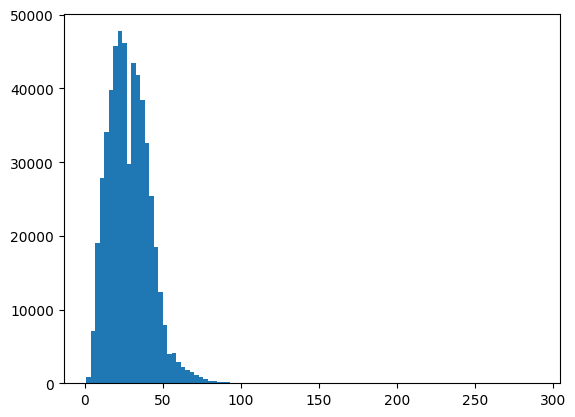

In [20]:
plt.hist([len(tokenized_title) for tokenized_title in df["tokenized_title"]], bins=100)
plt.show()

In [21]:
max_title_token_length = 50

In [22]:
def get_input_tensor(df, seq_len, vocab):
    df = df.reset_index(drop=True)
    data_tensor = torch.zeros((len(df), seq_len), dtype=torch.long)
    for i, row in df.iterrows():
        title = row["tokenized_title"]
        title = title[:seq_len]
        padded_title = title + ["[PAD]"] * (seq_len - len(title))
        for j, token in enumerate(padded_title):
            data_tensor[i][j] = vocab[token]
    return data_tensor


def get_label_tensor(df):
    return torch.tensor(df["category_label"].tolist())

train_input_tensor = get_input_tensor(train_df, max_title_token_length, vocab)
train_label_tensor = get_label_tensor(train_df)
test_input_tensor = get_input_tensor(test_df, max_title_token_length, vocab)
test_label_tensor = get_label_tensor(test_df)

In [75]:
class MLPModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dims, seq_length, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        hidden_layers = []
        for fan_in_dim, fan_out_dim in zip([embed_dim * seq_length] + hidden_dims[:-1], hidden_dims):
            hidden_layers.extend([
                nn.Linear(fan_in_dim, fan_out_dim),
                nn.ReLU(),
            ])
        self.hidden_layers = nn.ModuleList(hidden_layers)
        fc_fan_in_dim = hidden_dims[-1] if hidden_dims else embed_dim
        self.fc = nn.Linear(fc_fan_in_dim, num_classes)

    def forward(self, x):
        # print(f"input shape={x.shape}")
        x = self.embedding(x)
        # print(f"embedding shape={x.shape}")
        x = torch.reshape(x, x.shape[:-2] + (-1,))
        # print(f"concated shape={x.shape}")
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
        # print(f"last layer shape={x.shape}")
        x = self.fc(x)
        # print(f"output shape={x.shape}")
        return x

In [76]:
mlp_e32_512 = MLPModel(
    vocab_size=len(vocab),
    embed_dim=32,
    hidden_dims=[512],
    seq_length=max_title_token_length,
    num_classes=len(categories),
)

mlp_e32_512

MLPModel(
  (embedding): Embedding(23481, 32)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc): Linear(in_features=512, out_features=726, bias=True)
)

In [77]:
optimizer_mlp_e32_512 = torch.optim.Adam(mlp_e32_512.parameters(), lr=0.001)

In [78]:
def train(model, input_tensor, label_tensor, optimizer, batch_size=256, epochs=1, steps=None):
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        for i in range(0, input_tensor.shape[0], batch_size):
            batch_input_tensor = input_tensor[i:i+batch_size]
            # print(f"batch_input_tensor.shape={batch_input_tensor.shape}")
            batch_label_tensor = label_tensor[i:i+batch_size]
            # print(f"batch_label_tensor.shape={batch_label_tensor.shape}")
            optimizer.zero_grad()
            output = model(batch_input_tensor)
            # print(f"output.shape={output.shape}")
            loss = loss_fn(output, batch_label_tensor).mean()
            # print(f"loss.shape={loss.shape}")
            loss.backward()
            optimizer.step()
            # break
            if i / batch_size % 100 == 0:
                print(f"Epoch {epoch} step {i / batch_size} loss: {loss.item()}")
            if steps and i >= steps:
                    break
        end_time = time.time()
        print(f"Epoch {epoch} loss: {loss.item()}  time: {(end_time - start_time):.2f}s")
        # break
    return


def eval(model, input_tensor, label_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(label_tensor.view_as(pred)).type(torch.float).mean()
    print(f"Accuracy: {correct.item() * 100:.2f}%")

In [79]:
train(mlp_e32_512, train_input_tensor, train_label_tensor, optimizer_mlp_e32_512, batch_size=1024)

Epoch 0 step 0.0 loss: 6.5987629890441895
Epoch 0 step 100.0 loss: 5.268423080444336
Epoch 0 step 200.0 loss: 4.471011638641357
Epoch 0 step 300.0 loss: 3.885913848876953
Epoch 0 step 400.0 loss: 3.60478138923645
Epoch 0 loss: 3.659503936767578  time: 4.74s


In [26]:
print("Evaluating on train set:")
eval(mlp_e32_512, train_input_tensor, train_label_tensor)

print()
print("Evaluating on test set:")
eval(mlp_e32_512, test_input_tensor, test_label_tensor)

Evaluating on train set:
Accuracy: 35.68%

Evaluating on test set:
Accuracy: 31.71%


In [80]:
sum([p.numel() for p in mlp_e32_512.parameters()])

1943542

In [81]:
torch.cuda.is_available()

True

In [29]:
device_train_labels = train_label_tensor.to('cuda:0')

In [30]:
device_train_inputs = train_input_tensor.to('cuda:0')

In [82]:
device_mlp_e32_512 = MLPModel(
    vocab_size=len(vocab),
    embed_dim=32,
    hidden_dims=[512],
    seq_length=max_title_token_length,
    num_classes=len(categories),
)
device_mlp_e32_512.to('cuda:0')

device_mlp_e32_512

MLPModel(
  (embedding): Embedding(23481, 32)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc): Linear(in_features=512, out_features=726, bias=True)
)

In [83]:
device_optimizer_mlp_e32_512 = torch.optim.Adam(device_mlp_e32_512.parameters(), lr=0.001)

In [84]:
train(device_mlp_e32_512, device_train_inputs, device_train_labels, device_optimizer_mlp_e32_512, batch_size=1024)

Epoch 0 step 0.0 loss: 6.631504058837891
Epoch 0 step 100.0 loss: 5.2066330909729
Epoch 0 step 200.0 loss: 4.318513870239258
Epoch 0 step 300.0 loss: 3.9002766609191895
Epoch 0 step 400.0 loss: 3.5488791465759277
Epoch 0 loss: 3.496180772781372  time: 0.67s
